**Titanic- Machine Learning from Disaster**

In [323]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [324]:
from pathlib import Path
import tarfile
import urllib.request


def load_titanic_data():
    """
    Loads the Titanic dataset from a local file or downloads it from a URL if necessary.

    Returns:
      A list containing two pandas DataFrames: train and test datasets.
    """
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [325]:
train_data, test_data = load_titanic_data()

# Explore the data

Let's explore the data.

In [326]:
# Showing the three first patterns in the dataset.
train_data.head(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [327]:
train_data.set_index('PassengerId', inplace=True)

train_data.head(n=3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [328]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


- **PassengerId** is the unique id of passenger
- **Survived** is the target variable we are trying to predict (0 or 1):
    - 1 = Survived
    - 0 = Not Survived
- **Pclass** (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (1, 2 or 3):
    - 1 = Upper Class
    - 2 = Middle Class
    - 3 = Lower Class
- **Name** is the name of the passenger.
- **Sex** is the sex of the passenger.
- **Age** is the age of the passenger.
- **SibSp** is the total number of the passengers' siblings and spouse.
- **Parch** is the total number of the passengers' parents and children.
- **Ticket** is the ticket number of the passenger.
- **Fare** is the passenger fare.
- **Cabin** is the cabin number of the passenger.
- **Embarked** is the port of embarkation:
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

We notice that some features have missing values that we need to deal with. In particular the features **Age**, **Cabin** and **Embarked** have missing values. \
**Cabin** has too many missing values, so we will drop it. \
**Age** has some missing values, so we will fill them with the median age (we could replacing the missing values guessing the age from the other fields). \
**Embarked** has only 2 missing values, so we will fill them with the most common value.

Another thing to notice is that the features **Name**, **Ticket** are not useful for our model, so we will drop them.

Let's see the correlation between the features and the target variable **Survived**.

In [329]:
# Selecting the numerical attributes
train_data_num = train_data.select_dtypes(include=[np.number])
# Correlation matrix
corr_matrix = train_data_num.corr()
corr_matrix["Survived"].sort_values(ascending=False)[1:]

Fare      0.257307
Parch     0.081629
SibSp    -0.035322
Age      -0.077221
Pclass   -0.338481
Name: Survived, dtype: float64

Wee can see that the features **Fare** and **Pclass** have a high correlation with the target variable **Survived**. \
Others features like **Age**, **SibSp** and **Parch** have a low correlation with the target variable **Survived**, so we could drop them or transform them in new features.

For examples, seems that the people which travelled lonely have a lower probability to survive.

In [330]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]

train_data.loc[:, ["RelativesOnboard", "Survived"]
               ].groupby("RelativesOnboard").mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


As we can see people which travelled alone have a probability to survive of 30%, while people which travelled with 1 or 2 siblings/spouse have a probability to survive of 50%. The interesting thins is that people which travelled with 3 or more siblings/spouse have a probability to survive of 72%. Maybe this is because they were a children with their parents, with higher priority to be saved. 

If we bucketize the **Age** feature, we could see how different ranges of age have different probabilities to survive.

In [346]:
bins = [0, 18, 35, 60, np.inf]
labels = ['Children', 'Young', 'Adult', 'Old']
train_data['AgeBucket'] = pd.cut(train_data['Age'], bins=bins, labels=labels)

train_data.loc[:, ["AgeBucket", "Survived"]].groupby(
    "AgeBucket", observed=True).mean()

,Survived
AgeBucket,
Children,0.503597
Young,0.382682
Adult,0.400000
Old,0.227273


What emerges is that children have a higher probability to survive, while young and old people has a lower probability to survived.\
All older people which ages > 70 survived.


Ok, the reason that all older people with age > 70 survived is that there were only one person with such age, and he survived.
We can delete this bucket because it is not useful for our model.

In [347]:
# Drop the row where the age is > 70
train_data.drop(train_data[train_data["Age"] > 70].index, inplace=True)

# Preprocessing

In [348]:
# Reload the original dataset
train_data, _ = load_titanic_data()
train_data.set_index('PassengerId', inplace=True)

In [349]:
train_x = train_data.drop("Survived", axis=1)
train_y = train_data["Survived"].copy()

Once we have explored the data, we can start the preprocessing phase. What we want is to automate the process of preprocessing the data, so we can pass the raw data to the preprocessing function and get the preprocessed data.

What we want is to:

- Drop the columns **Name**, **Ticket** and **Cabin**, they are not useful for our model.
- Sum the columns **SibSp** and **Parch** in a new column **RelativeOnBoards**. Drop the columns **SibSp** and **Parch**.
- Fill the missing values of the column **Age** with the median age. Drop the older people with age > 70.
- Fill the missing values of the column **Embarked** with the most common value.
- Bucketize the column **Age** in 4 buckets: **Children**, **Young**, **Adult** and **Old**.
- Transform the **Pclass** in a categorical attribute (**First**, **Second**, **Third** class).
- Encode the categorical attributes. 

In [350]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [351]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [352]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.columns, axis=1)


class NumericalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)

    def fit(self, X, y=None):
        self.imputer.fit(X.select_dtypes(include=[np.number]))
        return self

    def transform(self, X):
        X_num = X.select_dtypes(include=[np.number])
        X[X_num.columns] = self.imputer.transform(X_num)
        return X


class NumericalScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=StandardScaler()):
        self.scaler = scaler

    def fit(self, X, y=None):
        self.scaler.fit(X.select_dtypes(include=[np.number]))
        return self

    def transform(self, X):
        X_num = X.select_dtypes(include=[np.number])
        X[X_num.columns] = self.scaler.transform(X_num)
        return X


class CategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='most_frequent'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)

    def fit(self, X, y=None):
        self.imputer.fit(X.select_dtypes(include=['object']))
        return self

    def transform(self, X):
        X_cat = X.select_dtypes(include=['object'])
        X[X_cat.columns] = self.imputer.transform(X_cat)
        return X


class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder()

    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.select_dtypes(
                include=['object', 'category']).columns.tolist()
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X):
        transformed_data = self.encoder.transform(X[self.columns])
        df = pd.DataFrame(transformed_data.toarray(
        ), columns=self.encoder.get_feature_names_out(self.columns), index=X.index)
        X = X.drop(self.columns, axis=1)
        X = pd.concat([X, df], axis=1)
        return X


class SumColumns(BaseEstimator, TransformerMixin):
    def __init__(self, col1, col2, new_col):
        self.col1 = col1
        self.col2 = col2
        self.new_col = new_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.new_col] = X[self.col1] + X[self.col2]
        return X.drop([self.col1, self.col2], axis=1)


class DropRows(BaseEstimator, TransformerMixin):
    def __init__(self, column, condition):
        self.column = column
        self.condition = condition

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.loc[~self.condition(X[self.column])]


class Bucketize(BaseEstimator, TransformerMixin):
    def __init__(self, column, bins, labels):
        self.column = column
        self.bins = bins
        self.labels = labels

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.column] = pd.cut(
            X[self.column], bins=self.bins, labels=self.labels)
        return X


class TransformPclass(BaseEstimator, TransformerMixin):
    def __init__(self, column, mapping):
        self.column = column
        self.mapping = mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.column] = X[self.column].map(self.mapping)
        return X


class AsCategory(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.column = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in self.column:
            X[self.column] = X[self.column].astype('category')
        return X

In [549]:
preprocessor = Pipeline(steps=[
    ('drop_columns', DropColumns(
        ['Name', 'Ticket', 'Cabin', 'Embarked'])),
    ('num_imputer', NumericalImputer('median')),
    ('cat_imputer', CategoricalImputer()),
    ('sum_columns', SumColumns('SibSp', 'Parch', 'RelativeOnBoards')),
    ('bucketize_age', Bucketize('Age', bins=[
     0, 18, 35, 60, np.inf], labels=['Children', 'Young', 'Adult', 'Old'])),
    ('transform_pclass', TransformPclass(
        'Pclass', {1: 'First', 2: 'Second', 3: 'Third'})),
    ('as_category', AsCategory(['Pclass', 'Sex', 'RelativeOnBoards'])),
    ('cat_encoder', CategoricalEncoder()),
    # ('scaler', NumericalScaler()),
])

In [550]:
preprocessed = preprocessor.fit_transform(train_data)

In [551]:
corr = preprocessed.corr()

corr["Survived"].sort_values(ascending=False)[1:]

Sex_female               0.543351
Pclass_First             0.285904
Fare                     0.257307
RelativeOnBoards_1.0     0.163157
RelativeOnBoards_2.0     0.143869
RelativeOnBoards_3.0     0.128347
Age_Children             0.105873
Pclass_Second            0.093349
Age_Adult                0.017590
RelativeOnBoards_6.0    -0.012134
RelativeOnBoards_4.0    -0.049466
Age_Old                 -0.051224
RelativeOnBoards_7.0    -0.064988
RelativeOnBoards_10.0   -0.070234
Age_Young               -0.077053
RelativeOnBoards_5.0    -0.080968
RelativeOnBoards_0.0    -0.203367
Pclass_Third            -0.322308
Sex_male                -0.543351
Name: Survived, dtype: float64

What we observe is that being a famale, of the first class, with a fare > 50 and embarked in Cherbourg, have a higher probability to survive.

# Models Fine Tuning

Once we have defined the preprocessing function, we can start to fine tune the models. We will use the following models:

In [530]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
# Import Knn
from sklearn.neighbors import KNeighborsClassifier

In [504]:
train_x_prepared = preprocessor.fit_transform(train_x)

train_x_prepared

,Fare,Pclass_First,Pclass_Second,Pclass_Third,Sex_female,Sex_male,Age_Adult,Age_Children,Age_Old,Age_Young,RelativeOnBoards_0.0,RelativeOnBoards_1.0,RelativeOnBoards_2.0,RelativeOnBoards_3.0,RelativeOnBoards_4.0,RelativeOnBoards_5.0,RelativeOnBoards_6.0,RelativeOnBoards_7.0,RelativeOnBoards_10.0
PassengerId,,,,,,,,,,,,,,,,,,,
1,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,13.0000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,30.0000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,23.4500,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [514]:
from sklearn.model_selection import GridSearchCV

In [515]:
forest_p_grid = [{"n_estimators": [
    100, 200, 300], "max_depth": [5, 10, 15]}]
forest_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42), forest_p_grid, cv=10, n_jobs=-1)

svm_p_grid = [{"C": [0.1, 1, 10], "gamma": [0.01, 0.1, 1, 10]},
              {"kernel": ["linear"], "C": [0.01, 0.1, 1, 10]}]
svm_grid_search = GridSearchCV(SVC(), svm_p_grid, cv=10, n_jobs=-1)

In [516]:
tree_p_grid = [{"max_depth": [5, 10, 15, None]}]

tree_grid_search = GridSearchCV(DecisionTreeClassifier(
    random_state=42), tree_p_grid, cv=10, n_jobs=-1)

In [517]:
sdg_p_grid = [
    {"loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"]}]

sdg_grid_search = GridSearchCV(SGDClassifier(), sdg_p_grid, cv=10, n_jobs=-1)

In [519]:
# Fit the models
forest_grid_search.fit(train_x_prepared, train_y)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid=[{'max_depth': [5, 10, 15],
                          'n_estimators': [100, 200, 300]}])

In [520]:
svm_grid_search.fit(train_x_prepared, train_y)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10]},
                         {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear']}])

In [521]:
tree_grid_search.fit(train_x_prepared, train_y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             n_jobs=-1, param_grid=[{'max_depth': [5, 10, 15, None]}])

In [627]:
forest_model = RandomForestClassifier(
    **forest_grid_search.best_params_, random_state=42)
svm_model = SVC(**svm_grid_search.best_params_, probability=True)

forest_model, svm_model

(RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42),
 SVC(C=10, gamma=1, probability=True))

In [603]:
tree_model = DecisionTreeClassifier(
    **tree_grid_search.best_params_, random_state=42)

# Model Selection

In [628]:
from sklearn.model_selection import cross_val_score

In [629]:
def evaluate_model(model):
    scores = cross_val_score(
        model, train_x_prepared, train_y, cv=10, scoring="accuracy")
    return pd.DataFrame(scores, columns=["Accuracy"])

In [630]:
forest_acc = evaluate_model(forest_model)
svm_acc = evaluate_model(svm_model)
tree_acc = evaluate_model(tree_model)

print(f"Accuracy for Random Forest: {forest_acc.mean().round(2)}")
print(f"Accuracy for SVM: {svm_acc.mean().round(2)}")
print(f"Accuracy for Decision Tree: {tree_acc.mean().round(2)}")

Accuracy for Random Forest: Accuracy    0.82
dtype: float64
Accuracy for SVM: Accuracy    0.81
dtype: float64
Accuracy for Decision Tree: Accuracy    0.83
dtype: float64


In [631]:
from sklearn.ensemble import VotingClassifier

In [671]:
voting_model = VotingClassifier(
    estimators=[('rf', forest_model), ('tree', tree_model)], voting='soft')

In [672]:
voting_model

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('tree',
                              DecisionTreeClassifier(max_depth=15,
                                                     random_state=42))],
                 voting='soft')

# Error analysis

Let's see the errors of the best model.

In [673]:
model = voting_model

In [674]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict

In [675]:
# See the confusion matrix on the training set
train_y_pred = cross_val_predict(
    model, train_x_prepared, train_y, cv=10)

In the confusion matrix we can see that the model has a good accuracy, but it has a low recall for the class 0. This means that the model is not able to predict the class 0 very well 

In [676]:
confusion_matrix(train_y, train_y_pred)

array([[482,  67],
       [ 87, 255]])

In [677]:
# Compute the recall, precision and f1 score
precision = precision_score(train_y, train_y_pred)
recall = recall_score(train_y, train_y_pred)
f1 = f1_score(train_y, train_y_pred)

print(f"Precision: {precision.round(2)}")
print(f"Recall: {recall.round(2)}")
print(f"F1 Score: {f1.round(2)}")

Precision: 0.79
Recall: 0.75
F1 Score: 0.77


In [678]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

train_y_scores = cross_val_predict(
    model, method="predict_proba", X=train_x_prepared, y=train_y, cv=10)

tpr, fpr, thresholds = roc_curve(train_y, train_y_scores[:, 1])

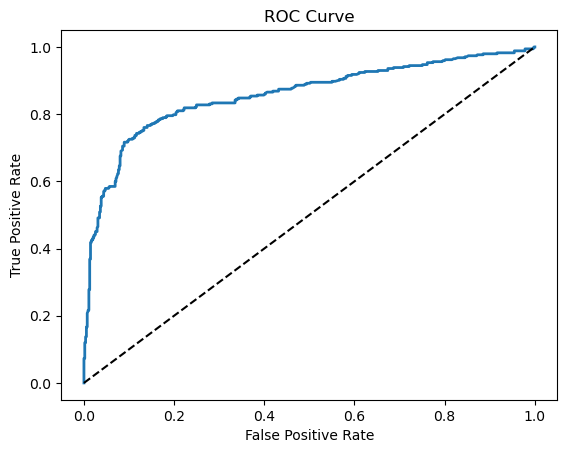

In [679]:
# Plot the ROC curve
plt.plot(tpr, fpr, linewidth=2)  # Plot the True Positive Rate
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

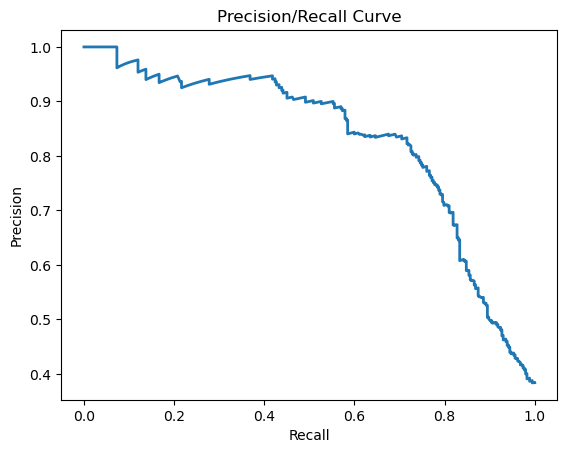

In [680]:
# PLot precision and recall
precision, recall, thresholds = precision_recall_curve(
    train_y, train_y_scores[:, 1])

plt.plot(recall, precision, linewidth=2)
# Plot the dashed diagonal
# plt.plot([0, 1], [1, 0], 'k--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve')
plt.show()